In [ ]:
import copy # copy variables
import os   # manage paths

import uproot   # use of root files
import awkward as ak    # nested, variable sized data
import vector   # lorentz vectors
vector.register_awkward()
import matplotlib.pyplot as plt # plotting
import atlasopenmagic as atom

from src.parse_atlas import (parser, consts, schemas, combinatorics)

import traceback
%load_ext autoreload
%autoreload 2

In [ ]:
#TESTING MC files
mc_rec_id = atlasparser.fetch_mc_files_ids('2024', is_random=True)
all_metadata = atom.get_metadata(mc_rec_id)
urls = atom.get_urls(mc_rec_id)
atlasparser.parsing_pipeline(schemas.GENERIC_SCHEMA, files_ids=urls)

In [ ]:
#TESTING MAIN PIPELINE
import main_pipeline

main_pipeline.run()

In [ ]:
#TEST FOR KEYS OF ROOT FILE
from src.parse_atlas import parser, schemas
import atlasopenmagic as atom
parse = parser.ATLAS_Parser()
rand_id = parse.fetch_mc_files_ids(
    '2024', is_random=True)
uri = atom.get_urls(rand_id)[0]
# testing = parse.testing_load_file_as_object(uri)
testing = parse._parse_file(
    schema=schemas.GENERIC_SCHEMA, 
    file_index=uri)

In [ ]:
dir(testing)
testing.fields

In [ ]:
GeV = 1000.

def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def selected_muons(mu):
    return mu[(mu.pt > 10 * GeV) & (abs(mu.eta) < 2.47)]

def selected_jets(j):
    return j[(j.pt > 10 * GeV) & (abs(j.eta) < 2.47)]

def no_overlap(obj1, obj2, deltaR=0.4):
    obj1, obj2 = ak.unzip(ak.cartesian([obj1, obj2], nested=True))
    return ak.all(obj1.deltaR(obj2) > deltaR, axis=-1)

def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return candidates.p4.mass

def processed(events):
    events = copy.copy(events) # shallow copy
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Jets"] = selected_jets(events.Jets)
    events["Jets"] = events.Jets[no_overlap(events.Jets, events.Electrons)]
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly one lepton
    ]
    return ak.to_packed(events)

events = processed(atlasparser.events)
plt.hist(ak.flatten(mjjj(events.Jets) / GeV, axis=None), bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', len(atlasparser.events))
print('Events after filtering:', len(events))

In [ ]:
def selected_electrons(el):
    return el[(el.pt > 10 * GeV) & (abs(el.eta) < 2.47)]

def electron_posi_muon_antimuon(events):
    events = copy.copy(events) # shallow copy
    events["Electrons"] = selected_electrons(events.Electrons)
    events["Muons"] = selected_muons(events.Muons)
    events["Electrons", "is_neg"] = events.Electrons.charge < 0
    events["Muons", "is_neg"] = events.Muons.charge < 0
    events = events[
        (ak.num(events.Electrons) == 2) 
        & (ak.num(events.Muons) == 2)
        # & (ak.num(events.Electrons[events.Electrons.is_neg]) == 1)
        # & (ak.num(events.Muons[events.Muons.is_neg]) == 1)
    ]
    return ak.to_packed(events)

events = electron_posi_muon_antimuon(atlasparser.events)
plt.hist(ak.flatten(events) / GeV, axis=None, bins=100)
plt.xlabel("Reconstructed Top Quark Mass (GeV)")
plt.ylabel("Number of Events")
plt.title("Distribution of Reconstructed Top Quark Mass")
plt.axvline(172.76, color='r', linestyle='dashed', linewidth=2, label='Expected Top Quark Mass')
plt.legend()
plt.show()

print('Total events:', len(atlasparser.events))
print('Events after filtering:', len(events))

In [ ]:
from src.parse_atlas import combinatorics, schemas

categories = combinatorics.make_objects_categories(schemas.PARTICLE_LIST, min_n=4, max_n=4)
print(json.dumps(categories, indent=4))

In [ ]:
import uproot

rootfile = "test/filtered.root"

with uproot.open(rootfile) as file:
    tree = file[file.keys()[0]]
    print(len(tree))

In [ ]:
from src.parse_atlas import parser, schemas

atlas = parser.ATLAS_Parser()
release_files_uris = atlas.fetch_mc_files_ids(
    release_year='2024')

with open("configs/file_ids_2024", "w+") as f:
    f.write("\n".join(release_files_uris))

In [ ]:
from src.parse_atlas import parser, schemas, combinatorics
import argparse, yaml, uproot


atlasparser = parser.ATLAS_Parser(1000000)

# atlasparser.load_events_from_file("output_dir/filtered_1.root")
with uproot.open("output_dir/filtered_1_test.root") as f:
    atlasparser.events = f["tree"]
e = atlasparser.events
arrays = e.arrays(library="ak")
print(arrays.fields)
print(type(arrays))
twojets_twoelectrons = atlasparser.filter_events_by_counts(
    arrays, {'nElectrons_eta': 2, 'nJets_eta': 4}, use_range=False)
inv_mass = atlasparser.calculate_mass_for_combination(twojets_twoelectrons) 

['nJets_rho', 'Jets_rho', 'nJets_phi', 'Jets_phi', 'nJets_eta', 'Jets_eta', 'nJets_tau', 'Jets_tau', 'nPhotons_rho', 'Photons_rho', 'nPhotons_phi', 'Photons_phi', 'nPhotons_eta', 'Photons_eta', 'nElectrons_rho', 'Electrons_rho', 'nElectrons_phi', 'Electrons_phi', 'nElectrons_eta', 'Electrons_eta', 'nElectrons_tau', 'Electrons_tau', 'nMuons_rho', 'Muons_rho', 'nMuons_phi', 'Muons_phi', 'nMuons_eta', 'Muons_eta']
<class 'awkward.highlevel.Array'>
Processing 658 events
Available fields: ['nJets_rho', 'Jets_rho', 'nJets_phi', 'Jets_phi', 'nJets_eta', 'Jets_eta', 'nJets_tau', 'Jets_tau', 'nPhotons_rho', 'Photons_rho', 'nPhotons_phi', 'Photons_phi', 'nPhotons_eta', 'Photons_eta', 'nElectrons_rho', 'Electrons_rho', 'nElectrons_phi', 'Electrons_phi', 'nElectrons_eta', 'Electrons_eta', 'nElectrons_tau', 'Electrons_tau', 'nMuons_rho', 'Muons_rho', 'nMuons_phi', 'Muons_phi', 'nMuons_eta', 'Muons_eta']
Found particle types: {'Electrons', 'Jets', 'Photons', 'Muons'}
Processing Electrons...
  Electr

Saved histogram data to BumpNet-main/baseline/histograms_test/
Number of events: 658
Mean invariant mass: 429961.10
Median invariant mass: 331665.97
Standard deviation: 331139.89
Minimum invariant mass: 72150.34
Maximum invariant mass: 2626548.69


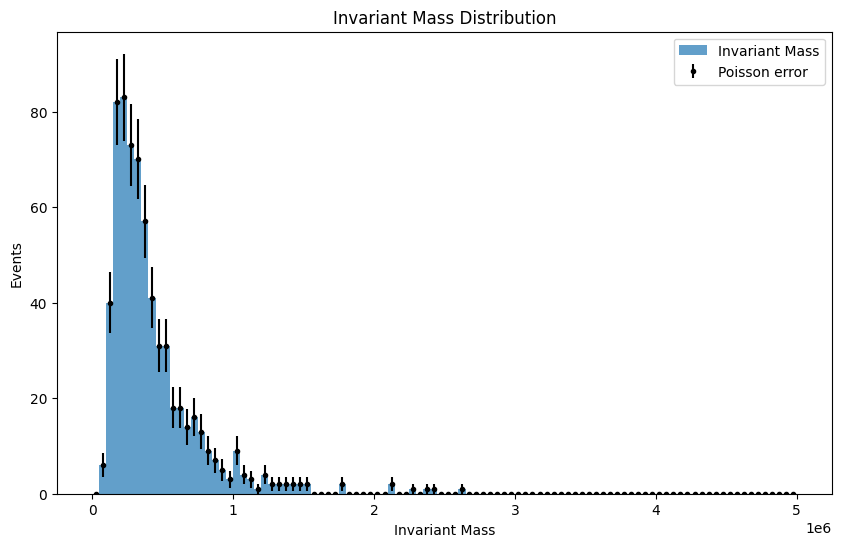

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Your invariant masses (replace with your actual array)
inv_masses = inv_mass  # The 45,372 values you computed

# Create histogram
n_bins = 100  # Adjust based on your needs
mass_min, mass_max = 0, 5000000  # Adjust range as needed

bin_content, bin_edges = np.histogram(inv_masses, bins=n_bins, range=(mass_min, mass_max))
bin_errors = np.sqrt(bin_content)  # Poisson errors

# Create the data structure your smoothing script expects
histogram_data = {
    'names': ['invariant_mass_distribution'],
    'bin_content': [bin_content],
    'bin_edges': [bin_edges],
    'bin_errors': [bin_errors]
}

# Save in the format your script expects
output_dir = 'BumpNet-main/baseline/histograms_test'
os.makedirs(output_dir, exist_ok=True)

# np.save(f'{output_dir}/names.npy', np.array(histogram_data['names'], dtype=object))
# np.save(f'{output_dir}/bin_content.npy', np.array(histogram_data['bin_content'], dtype=object))
# np.save(f'{output_dir}/bin_edges.npy', np.array(histogram_data['bin_edges'], dtype=object))
# np.save(f'{output_dir}/bin_errors.npy', np.array(histogram_data['bin_errors'], dtype=object))

print(f"Saved histogram data to {output_dir}/")

print(f"Number of events: {len(inv_mass)}")
print(f"Mean invariant mass: {np.mean(inv_mass):.2f}")
print(f"Median invariant mass: {np.median(inv_mass):.2f}")
print(f"Standard deviation: {np.std(inv_mass):.2f}")
print(f"Minimum invariant mass: {np.min(inv_mass):.2f}")
print(f"Maximum invariant mass: {np.max(inv_mass):.2f}")
plt.figure(figsize=(10,6))
plt.hist(bin_edges[:-1], bins=bin_edges, weights=bin_content, alpha=0.7, label='Invariant Mass')
plt.errorbar((bin_edges[:-1] + bin_edges[1:]) / 2, bin_content, yerr=bin_errors, fmt='.', color='black', label='Poisson error')
plt.xlabel('Invariant Mass')
plt.ylabel('Events')
plt.title('Invariant Mass Distribution')
plt.legend()
plt.show()